```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [ ]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if p.endswith("gpuocean/src")][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

# Oslofjord
Testing of Nils projected files

In [ ]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [ ]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [ ]:
%cuda_context_handler gpu_ctx

Path to the test file

In [ ]:
source_url = "/sintef/data/OsloFjord/test_polstere.nc"

Animation utils

In [ ]:
from IPython.display import clear_output
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
from mpl_toolkits.axes_grid1 import make_axes_locatable

from gpuocean.utils import PlotHelper
from gpuocean.utils.NetCDFInitialization import depth_integration

def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, red_grav_mode=False,
                 comment = "Oslo",
                 h_min=-0.25, h_max=0.25, 
                 uv_min=-10, uv_max=10,
                 ax=None, sp=None, quiv=None):


    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
    
    x_plots = 4
    y_plots = 1
   
    huv_label = ["hv","hu"]

    # Prepare quiver
    u = hu/h
    v = hv/h
    velocity = np.sqrt(u*u + v*v)
    
    frequency_x = 20
    frequency_y = 20
    x = np.arange(0, eta.shape[1], frequency_x)*dx
    y = np.arange(0, eta.shape[0], frequency_y)*dy
    u = u[::frequency_y, ::frequency_x]
    v = v[::frequency_y, ::frequency_x]

    if red_grav_mode:
        eta = -eta
        h_min = -15
        h_max = 0

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots

        uv_cmap = plt.cm.coolwarm
        uv_cmap.set_bad("grey", alpha = 1.0)
        
        h_cmap = plt.cm.coolwarm
        h_cmap.set_bad("grey", alpha = 1.0)
        if red_grav_mode:
            h_cmap = plt.cm.Blues_r
            h_cmap.set_bad("grey", alpha = 1.0)

        velo_cmap = plt.cm.Reds
        velo_cmap.set_bad("grey", alpha = 1.0)

        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='lower', 
                             cmap=h_cmap, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.axis('image')
        plt.title("$\zeta{}$")
        divider0 = make_axes_locatable(ax[0])
        cax0 = divider0.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[0],cax=cax0)


        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                            cmap=uv_cmap, 
                            vmin=uv_min, vmax=uv_max, 
                            extent=domain_extent)
        plt.axis('image')
        plt.title("$"+huv_label[0]+"$")
        divider1 = make_axes_locatable(ax[1])
        cax1 = divider1.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[1],cax=cax1)



        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=uv_cmap, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.axis('image')
        plt.title("$"+huv_label[1]+"$")
        divider2 = make_axes_locatable(ax[2])
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[2],cax=cax2)

        ax[3] = plt.subplot(y_plots, x_plots, 4)
        sp[3] = ax[3].imshow(velocity, interpolation="none", origin='lower', 
                             cmap="Reds", 
                             vmin=0, vmax=2.5, 
                             extent=domain_extent)
        quiv = ax[3].quiver(x,y,v,u)
        plt.axis('image')
        plt.title("$v$")
        divider2 = make_axes_locatable(ax[3])
        cax3 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[3],cax=cax3)

        plt.tight_layout()
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)

        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)

        fig.sca(ax[3])
        sp[3].set_data(hv)
        quiv.set_UVC(u, v)
    
    return ax, sp, quiv


def ncAnimation(filename, nctype, **kwargs):
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(20, 6))

    ncfile = Dataset(filename)

    red_grav_mode = False

    if nctype == "ROMS":
        t = ncfile.variables['ocean_time'][:]

        eta = np.ma.array(ncfile["zeta"][:,1:-1,1:-1], mask=len(t)*[1-ncfile["mask_rho"][1:-1,1:-1]])
        u   = np.ma.array(ncfile["ubar"][:,1:-1,:], mask=len(t)*[1-ncfile["mask_rho"][1:-1,:-1]])
        v   = np.ma.array(ncfile["vbar"][:,:,1:-1], mask=len(t)*[1-ncfile["mask_rho"][:-1,1:-1]])

        u   = (u[:,:,1:] + u[:,:,:-1])/2
        v   = (v[:,1:,:] + v[:,:-1,:])/2

        H_m = np.ma.array(ncfile["h"][1:-1,1:-1], mask=[1-ncfile["mask_rho"][1:-1,1:-1]])

        hu = u*H_m
        hv = v*H_m

    elif nctype == "gpuocean":
        t = ncfile["time"][:]

        eta = ncfile["eta"][:]
        hu  = ncfile["hu"][:]
        hv  = ncfile["hv"][:]

        H_m = ncfile["Hm"][:]

    elif nctype == "gpuocean-reduced_grav":
        t = ncfile["time"][:]

        eta = ncfile["eta"]
        hu  = ncfile["hu"][:]
        hv  = ncfile["hv"][:]

        H_m = ncfile["Hm"][:]
        
        red_grav_mode = True

        

    movie_frames = len(t)

    dx = 50
    dy = 50
    
    ax, sp, quiv = plotSolution(fig, 
                            eta[0],
                            hu[0],
                            hv[0],
                            H_m,
                            dx, dy, 
                            t[0], 
                            red_grav_mode,
                            **kwargs)


    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                        ((1-s)*eta[j] + s*eta[k]), 
                        ((1-s)*hu[j]  + s*hu[k]), 
                        ((1-s)*hv[j]  + s*hv[k]), 
                        (H_m+(1-s)*eta[j] + s*eta[k]), 
                        dx, dy, 
                        t_now, 
                        red_grav_mode,
                        **kwargs, ax=ax, sp=sp, quiv=quiv)

        clear_output(wait = True)
        #print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=250)
    plt.close(fig)
    
    return anim


Init

In [ ]:
nc = Dataset(source_url)
dimY, dimX = nc.dimensions["eta_rho"].size, nc.dimensions["xi_rho"].size

In [ ]:
x0, x1, y0, y1 = 5, dimX-5, 135, dimY-5

In [ ]:
from importlib import reload
reload(NetCDFInitialization)

data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, norkyst_data=False, download_data=False, land_value=0.0)

Mixed Layer Init

In [ ]:
mld = NetCDFInitialization.MLD(source_url, 1023, min_mld=5, max_mld=40, x0=x0, x1=x1, y0=y0, y1=y1)

In [ ]:
s_nc = Dataset(source_url)
s_hs = s_nc["h"][y0:y1,x0:x1]

bad_yx = np.where(np.logical_or(np.abs(mld - s_hs) < 0.35*s_hs, np.abs(mld - s_hs) < 3))
bad_mask = np.where(np.logical_and((s_hs!=0.0), np.logical_and(np.abs(mld - s_hs) > 0.35*s_hs, np.abs(mld - s_hs) > 3)),0,1)

Xidx = np.arange(0, mld.shape[1])
Yidx = np.arange(0, mld.shape[0])

xx, yy = np.meshgrid(Xidx, Yidx)

K = 20

for i in range(len(bad_yx[0])):
    dists = (xx-bad_yx[1][i])**2 + (yy-bad_yx[0][i])**2 + 1e5*bad_mask
    sum = 0.0
    for k in range(K): 
        sum += mld[np.unravel_index(dists.argmin(), dists.shape)]
        dists[np.unravel_index(dists.argmin(), dists.shape)] = 1e5
    mld[bad_yx[0][i],bad_yx[1][i]] = sum/K

In [ ]:
mld = NetCDFInitialization.fill_coastal_data(mld)

Reference `H`

In [ ]:
H = 2.0

Osciallating BC

In [ ]:
from gpuocean.utils import Common

In [ ]:
NX = data_args["nx"]+4
NY = data_args["ny"]+4

In [ ]:
freq = 12*3600 #INPUT: Frequency of oscillating BCs
T = 14*24*3600  #INPUT: Max time for simulation

t_step = freq/12 # seconds between now BC data
T_steps = int(np.ceil(T/t_step)+1) # number of BC data in time

ts = np.arange(0, T+1, step=t_step)

In [ ]:
ampl = 1.0 #INPUT: BC current in m/s
bc_eta = ampl*np.ones((T_steps, NX)) * np.sin(2*np.pi*ts/freq)[:,np.newaxis]

In [ ]:
bc_h = np.tile(mld[0], (T_steps,1)) + bc_eta

In [ ]:
south = Common.SingleBoundaryConditionData(h=(bc_h-H).astype(np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=np.zeros((T_steps, NX), dtype=np.float32))
north = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NX), dtype=np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=np.zeros((T_steps, NX), dtype=np.float32))
east  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))
west  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))

In [ ]:
data_args["boundary_conditions_data"] = Common.BoundaryConditionsData(ts, north=north, south=south, east=east, west=west)

Text(0, 0.5, 'h [m]')

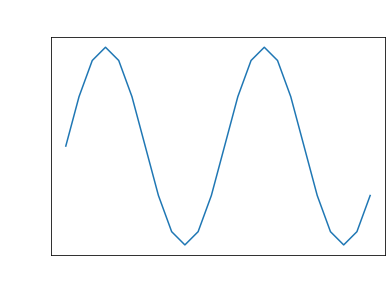

In [33]:
plt.plot((ts/3600)[:int(24*3600/t_step)], bc_h[:int(24*3600/t_step),190])
plt.title("h forcing from the south boundary \n (at a point in middle of Drøbak sill)")
plt.xlabel("time [h]")
plt.ylabel("h [m]")

### Baroclinic model

In [29]:
data_args["H"] = np.ma.array(H*np.ones_like(data_args["H"]), mask=data_args["H"].mask.copy(), dtype=np.float32)

In [30]:
data_args["eta0"] = np.ma.array(mld.data - H, mask=copy.copy(mld.mask))
data_args["hu0"] = np.ma.array(np.zeros_like(mld), mask=copy.copy(mld.mask))
data_args["hv0"] = np.ma.array(np.zeros_like(mld), mask=copy.copy(mld.mask))

In [31]:
from gpuocean.SWEsimulators import CDKLM16
osc_sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0,  **NetCDFInitialization.removeMetadata(data_args), write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [ ]:
sub_t = 3600*6

for t in range(int(T/sub_t)):#range(T/blabla):
    osc_sim.step(sub_t)

In [ ]:
ncAnimation(osc_sim.sim_writer.output_file_name, "gpuocean-reduced_grav")